### Mount Google Drive

In [0]:
from google.colab import drive 
drive.mount("/content/drive") 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!sudo pip install h5py

### Importing Libraries

In [0]:
import glob
import cv2
import re
import numpy as np
import random
import matplotlib.pyplot as plt
#import tqdm as tqdm
from tqdm.notebook import tqdm

from tensorflow import keras

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.models import load_model
from tensorflow.keras import utils
#from keras.utils.np_utils import to_categorical 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import DirectoryIterator
from tensorflow.keras.applications.resnet import preprocess_input

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

from sklearn.model_selection import train_test_split


### Set the directory

In [0]:
import os
os.chdir("/content/drive/My Drive/Other/data")

### Train and Test Data Path

In [0]:
import pathlib
train_dir = pathlib.Path("train")
test_dir = pathlib.Path("test")

In [0]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

### Define Train and Test Data generator

In [0]:
train_data_generator = ImageDataGenerator(rescale=1./255,preprocessing_function = preprocess_input, width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1, horizontal_flip=True,
                      validation_split=0.30)

test_data_generator = ImageDataGenerator(rescale=1./255,preprocessing_function = preprocess_input)

### Read the Train data as two parts - Train and Validation

In [0]:

train_generator = train_data_generator.flow_from_directory(train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=1,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = train_data_generator.flow_from_directory(train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=1,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 3780 images belonging to 15 classes.
Found 1620 images belonging to 15 classes.


### Read the Test Data

In [0]:
test_generator = test_data_generator.flow_from_directory(test_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=50,
                                                     class_mode='categorical', batch_size=BATCH_SIZE)


Found 1800 images belonging to 15 classes.


### Check the categoriess

In [0]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*')]) 

In [0]:
CLASS_NAMES

array(['bedroom', 'beach', 'airport_terminal', 'skyscraper',
       'forest_path', 'Cathedral_outdoor', 'bridge', 'house',
       'market_outdoor', 'playground', 'restaurant', 'coral_reef',
       'dining_room', 'highway', 'mountain'], dtype='<U17')

### No of data points for each part

In [0]:
print("No of Training Images:",train_generator.n)
print("No of Validation Images:",validation_generator.n)
print("No of Test Images:",test_generator.n)

No of Training Images: 3780
No of Validation Images: 1620
No of Test Images: 1800


### Check shape of one train batch

In [0]:
train_generator.__getitem__(0)[0].shape

(32, 224, 224, 3)

In [0]:
## To check no of images per category in train data
# for i in range(len(CLASS_NAMES)):
#   print(CLASS_NAMES[i])
#   print(len(list(train_dir.glob(str(CLASS_NAMES[i]) +'/*'))))

### Visualization 

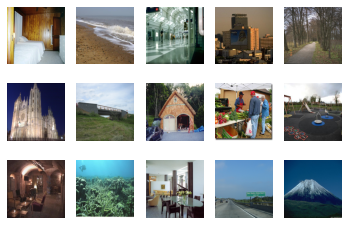

In [0]:
from PIL import Image
import random


rows = 3
cols = 5
k = 0
fig, axs = plt.subplots(rows, cols)
for i in range(rows):
  for j in range(cols):
    r = random.randrange(0, 200, 1)
    path = list(train_dir.glob(str(CLASS_NAMES[k]) +'/*'))[r]
    img = Image.open(path)
    img = img.resize((500,500), Image.ANTIALIAS)

    axs[i,j].imshow(img)
    axs[i,j].axis('off')
    #axs[i,j].set_title(str(CLASS_NAMES[k]))
    k = k + 1  

### Define Model

### Pre-trained Model

In [0]:
base_model = InceptionResNetV2(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights="imagenet") 
# flat1 = Flatten()
# dense_1 = Dense128, activation = "relu")
# model = Model(inputs=base_model.inputs, outputs=output) 
base_model.trainable = False

219062272/219055592 [==============================] - 3s 0us/step


In [0]:
print("No of layers now in the base model:",len(base_model.layers))

No of layers now in the base model: 780


### Summary of Base Model

In [0]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

### Define the callback functions

In [0]:
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.001, patience= 20, verbose= 1, mode='auto', baseline=None, restore_best_weights=False)
mcp = ModelCheckpoint("best_model.h5", monitor='val_accuracy', verbose= 1, save_best_only= True, save_weights_only=False, mode='auto', period=1)
rlr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience= 3, verbose=1, mode='auto', min_lr=0)


#### Define our model using base model

In [0]:
model = Sequential([base_model])
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation = "relu"))
#model.add(BatchNormalization())
model.add(Dropout(0.25))
# model.add(Dense(128, activation = "relu"))
# model.add(Dropout(0.5))
model.add(Dense(15, activation = "softmax"))

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
#optimizer = RMSprop(learning_rate=0.001)


model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### Summary of final model

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
batch_normalization_203 (Bat (None, 38400)             153600    
_________________________________________________________________
dense (Dense)                (None, 256)               9830656   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                3855      
Total params: 64,324,847
Trainable params: 9,911,311
Non-trainable params: 54,413,536
____________________________________

### Fit model

In [0]:
## Define epoch, steps
EPOCHS = 20
steps_per_epoch = 50 #train_generator.__len__() 
validation_steps = 30 #validation_generator.__len__() 


history = model.fit(train_generator,
	 steps_per_epoch= steps_per_epoch, validation_data=validation_generator, validation_steps = validation_steps,
	epochs=EPOCHS, verbose =1, callbacks=[mcp,rlr])

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 0.9284 - accuracy: 0.7706 
Epoch 00001: val_accuracy improved from -inf to 0.84271, saving model to best_model.h5
50/50 [==============================] - 1121s 22s/step - loss: 0.9284 - accuracy: 0.7706 - val_loss: 0.5828 - val_accuracy: 0.8427 - lr: 1.0000e-04
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 0.5886 - accuracy: 0.8600 
Epoch 00002: val_accuracy improved from 0.84271 to 0.86603, saving model to best_model.h5
50/50 [==============================] - 1052s 21s/step - loss: 0.5886 - accuracy: 0.8600 - val_loss: 0.5629 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 0.5159 - accuracy: 0.8899
Epoch 00003: val_accuracy improved from 0.86603 to 0.89896, saving model to best_model.h5
50/50 [==============================] - 349s 7s/step - loss: 0.5159 - accuracy: 0.8899 - val_loss: 0.5042 - val_accuracy: 0.8990 - lr: 1.0000e-04
Epoc

### Validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate(validation_generator, steps = validation_steps)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

30/30 [==============================] - 19s 636ms/step - loss: 0.4454 - accuracy: 0.9146
Validation loss: 0.44538313150405884
Validation accuracy: 0.9145833253860474


### Test loss and accuracy

In [0]:
print("No of test batches:",test_generator.__len__())

No of test batches: 57


In [0]:
test_loss, test_acc = model.evaluate(test_generator, steps = 57)
print("Test loss:", test_loss) 
print("Test accuracy:", test_acc)

57/57 [==============================] - 716s 13s/step - loss: 0.3481 - accuracy: 0.9283
Test loss: 0.3480552136898041
Test accuracy: 0.9283333420753479


### Plot of accuracy and loss with epoch

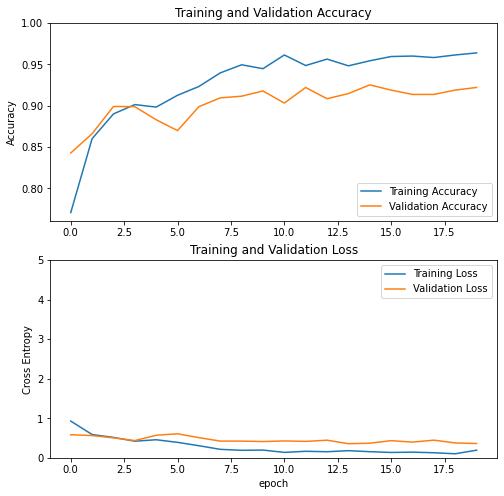

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,5.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine tune the model
#### Unfreezing the layers of pre-trained model

In [0]:
base_model.trainable =True

In [0]:
# No of layers
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
## Here we learn all the weights, so the 0 below
fine_tune_at = 720

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  780


### Compile the model

In [0]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

### Model Summary

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
batch_normalization_203 (Bat (None, 38400)             153600    
_________________________________________________________________
dense (Dense)                (None, 256)               9830656   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                3855      
Total params: 64,324,847
Trainable params: 20,717,167
Non-trainable params: 43,607,680
___________________________________

### Fit the model again after fine tuning

In [0]:
fine_tune_epochs = 10
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(train_generator,
	 steps_per_epoch= steps_per_epoch, validation_data=validation_generator, epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],validation_steps = validation_steps,
	                      verbose =1, callbacks=[mcp,rlr])

Epoch 20/30
50/50 [==============================] - ETA: 0s - loss: 0.3417 - accuracy: 0.8994
Epoch 00020: val_accuracy did not improve from 0.92511
50/50 [==============================] - 76s 2s/step - loss: 0.3417 - accuracy: 0.8994 - val_loss: 0.4081 - val_accuracy: 0.9188 - lr: 4.0000e-06
Epoch 21/30
50/50 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.9332
Epoch 00021: val_accuracy did not improve from 0.92511
50/50 [==============================] - 71s 1s/step - loss: 0.2058 - accuracy: 0.9332 - val_loss: 0.3759 - val_accuracy: 0.9167 - lr: 4.0000e-06
Epoch 22/30
50/50 [==============================] - ETA: 0s - loss: 0.1769 - accuracy: 0.9375
Epoch 00022: val_accuracy did not improve from 0.92511
50/50 [==============================] - 73s 1s/step - loss: 0.1769 - accuracy: 0.9375 - val_loss: 0.3176 - val_accuracy: 0.9230 - lr: 4.0000e-06
Epoch 23/30
50/50 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9529
Epoch 00023: val_

### Validation loss and accuracy

In [0]:
print("No of validation batches:",validation_generator.__len__())

No of validation batches: 51


In [0]:
val_loss, val_acc = model.evaluate(validation_generator, steps = 51)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

51/51 [==============================] - 33s 653ms/step - loss: 0.4022 - accuracy: 0.9093
Validation loss: 0.4021892547607422
Validation accuracy: 0.9092592597007751


### Test loss and accuracy

In [0]:
print("No of test batches:",test_generator.__len__())

No of test batches: 57


In [0]:
test_loss, test_acc = model.evaluate(test_generator, steps = 57)
print("Test loss:", test_loss) 
print("Test accuracy:", test_acc)

57/57 [==============================] - 35s 618ms/step - loss: 0.3605 - accuracy: 0.9239
Test loss: 0.36047765612602234
Test accuracy: 0.9238888621330261


### Plot

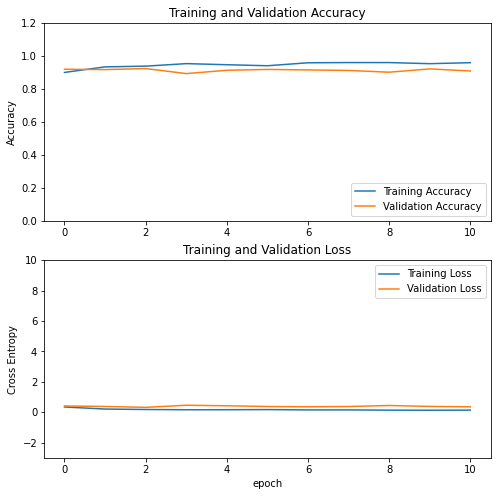

In [0]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.2])
#plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([-3,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()